# NIH Sickle Cell Research Analysis

Welcome to this exploratory data science project focused on NIH-funded sickle cell research. This analysis aims to investigate how National Institutes of Health (NIH)'s NHLBI (National Heart Lung Blood Institute) allocates funding to sickle cell projects, with a particular focus on those aligned with the **Cure Sickle Cell Initiative**. Using publicly available data from NIH RePORTER, we examine:

- The distribution of research funding across institutions, investigators, and geographic regions  
- Trends in project focus areas (e.g., sickle cell disease, gene therapy, clinical trials)  
- How individual projects align with the goals of NHLBI's Cure Sickle Cell Initiative  

The goal of this notebook is not only to extract and visualize relevant patterns in the data, but also to gain insight into how large-scale biomedical initiatives are financially supported. This work contributes to a deeper understanding of how public funding shapes the landscape of sickle cell disease research in the United States.

**Tools Used**: Python (Pandas, Matplotlib, Seaborn, sklearn, numpy, os), Jupyter Notebook, NIH RePORTER CSV exports  

# Dependencies

In [16]:
# Install package for natural language processing (run once)
%pip install nltk

# data manipulation
import pandas as pd
import numpy as np
import os

# text analysis tools
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import SnowballStemmer
import string

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# autosave every 60 seconds (optional)
%autosave 60

Note: you may need to restart the kernel to use updated packages.


Autosaving every 60 seconds


# Set Paths

In [17]:
# Convert scientific notation to a full float
pd.set_option('display.float_format', '{:.2f}'.format)

In [18]:
# Convert scientific notation to a full float
pd.set_option('display.float_format', '{:.2f}'.format)

In [19]:
# Set the path to the "Data" folder by replacing "Notebooks" in the current directory path
path = str(os.getcwd()).replace("Notebooks", "Data")

# If the data has been moved, manually set the path below (not recommended for reproducibility)
# path = '...'  # Uncomment and update if needed

# Print the path to verify correctness (varies by computer)
print(path)

C:\Users\NAjani\Jupyter\Wagner\SickleCellProject


## Background: The Cure Sickle Cell Initiative

The **Cure Sickle Cell Initiative (CureSCi)** began in 2018. It is a collaborative research effort launched by the National Heart, Lung, and Blood Institute (NHLBI) to accelerate the development of genetic-based cures for sickle cell disease (SCD). SCD is a hereditary blood disorder that disproportionately affects African American and other minority populations in the United States. Despite being recognized for over a century, curative treatments remain limited, and disparities in care and outcomes persist.

CureSCi seeks to coordinate efforts across government, academia, and industry to develop safe, effective, and widely accessible genetic therapies. Its goals include:

- Advancing **gene-editing and gene-therapy approaches** as potential cures  
- Enhancing **data sharing** and **patient engagement** in the research process  
- Supporting the **translation of laboratory discoveries into clinical applications**  

The initiative emphasizes not only scientific innovation but also equitable access, stakeholder collaboration, and the long-term sustainability of curative treatments.

---

## Project Focus

In this notebook, I explore how NIH funding is being allocated to support projects aligned with the goals of the Cure Sickle Cell Initiative. Specifically, I am interested in:

- **The extent to which funded projects align with the CureSCi mission**, including efforts to address health disparities and promote patient-centered research
- **What types of projects** (e.g., clinical trials, gene therapy, implementation science) are being supported  
- **How funding patterns vary** across time   

This analysis uses data extracted from the NIH RePORTER system, offering a data-driven perspective on how federal investments are shaping the future of sickle cell research and potential cures.

---

**Reference**: [Cure Sickle Cell Initiative – NHLBI](https://www.nhlbi.nih.gov/science/cure-sickle-cell-initiative)


In [20]:
# read in a csv file of grants using pd.read_csv() function
df = pd.read_csv(path + '/SickleCell_Gene_Allyrs.csv', encoding='latin-1')

## Previewing the Dataset

To begin exploring the data, we’ll take a look at the first five rows using the `head()` function. This will give us a quick sense of the dataset’s structure and the types of information it contains.

In [21]:
# See first 5 rows with head() function
df.head(5)

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Award Notice Date,Opportunity Number,Project Number,Type,...,CFDA Code,Funding Mechanism,Fiscal Year,Total Cost,Total Cost(Sub Projects),Funding IC(s),Direct Cost IC,Indirect Cost IC,NIH COVID-19 Response,Total Cost IC
0,Clinical Research; Hematology; Rare Diseases; ...,Clinical Trials;Collaborations;Data Set;Diseas...,Collaborative Health Research Initiative Progr...,NaN,NHLBI,10975134,,,AHL14007001-1-0-1,,...,,Interagency Agreements,2023,606874,,NHLBI,,,,606874
1,Biotechnology; Clinical Research; Clinical Tri...,Advocate;Caregivers;Collaborations;Communities...,Cure Sickle Cell,NaN,NHLBI,10934820,9/26/2023,OTA-18-003,3OT3HL147741-01S4,3,...,837,Other,2023,3729772,,NHLBI,3729772,0,,3729772
2,Biotechnology; Hematology; Rare Diseases; Sick...,Address;Agreement;Annual Reports;Award;Biotech...,CureSC Manufacturing Resource Platform,NaN,NHLBI,10934634,9/26/2023,OTA-19-010,3OT3HL152932-01S3,3,...,837,Other,2023,1389793,,NHLBI,1389793,0,,1389793
3,Biotechnology; Cancer; Clinical Research; Clin...,Accounting;Acute Graft Versus Host Disease;Ado...,Allogeneic and Autologous Immunotherapy for ca...,NaN,NHLBI,10934196,,,1ZIAHL002345-23,1,...,,Intramural Research,2023,4208801,,NHLBI,,,,4208801
4,Clinical Research; Clinical Trials and Support...,Adverse event;Biological Markers;Cellular Meta...,A Phase 1 Study to Evaluate the Safety and Tol...,NaN,NHLBI,10930552,,,1ZIAHL006284-01,1,...,,Intramural Research,2023,114449,,NHLBI,,,,114449


In [22]:
df.columns

Index(['NIH Spending Categorization', 'Project Terms', 'Project Title',
       'Public Health Relevance', 'Administering IC', 'Application ID',
       'Award Notice Date', 'Opportunity Number', 'Project Number', 'Type',
       'Activity', 'IC', 'Serial Number', 'Support Year', 'Suffix',
       'Program Official Information', 'Project Start Date',
       'Project End Date', 'Study Section', 'Subproject Number',
       'Contact PI Person ID', 'Contact PI / Project Leader',
       'Other PI or Project Leader(s)', 'Congressional District', 'Department',
       'Primary DUNS', 'Primary UEI', 'DUNS Number', 'UEI', 'FIPS', 'Latitude',
       'Longitude', 'Organization ID (IPF)', 'Organization Name',
       'Organization City', 'Organization State', 'Organization Type',
       'Organization Zip', 'Organization Country', 'ARRA Indicator',
       'Budget Start Date', 'Budget End Date', 'Post Award Action Type',
       'CFDA Code', 'Funding Mechanism', 'Fiscal Year', 'Total Cost',
       'Total C

In [23]:
df.shape

(4245, 53)

In [24]:
df.dtypes

NIH Spending Categorization      object
Project Terms                    object
Project Title                    object
Public Health Relevance          object
Administering IC                 object
Application ID                    int64
Award Notice Date                object
Opportunity Number               object
Project Number                   object
Type                             object
Activity                         object
IC                               object
Serial Number                    object
Support Year                     object
Suffix                           object
Program Official Information     object
Project Start Date               object
Project End Date                 object
Study Section                    object
Subproject Number                object
Contact PI Person ID             object
Contact PI / Project Leader      object
Other PI or Project Leader(s)    object
Congressional District           object
Department                       object


In [25]:
# To check the total number of unique projects

df["Project Number"].nunique()

3526

Remove dollar signs ($) from data inorder to convert data from strings to floats

In [26]:
cost_cols = [
    'Total Cost', 'Total Cost(Sub Projects)',
    'Direct Cost IC', 'Indirect Cost IC', 'Total Cost IC'
]

for c in cost_cols:
    df[c] = (
        df[c]
        .replace(r'[$,]', '', regex=True)   # remove $ and commas
        .replace(r'^\s*$', None, regex=True)  # convert blank strings to NaN
        .astype(float)
    )

## Trends in Funded Projects Over Time 

To understand how NIH support for sickle cell research has evolved, we visualize the number of unique projects funded each fiscal year. This line graph shows trends in project counts over time, helping us identify periods of increased investment or shifts in research activity.

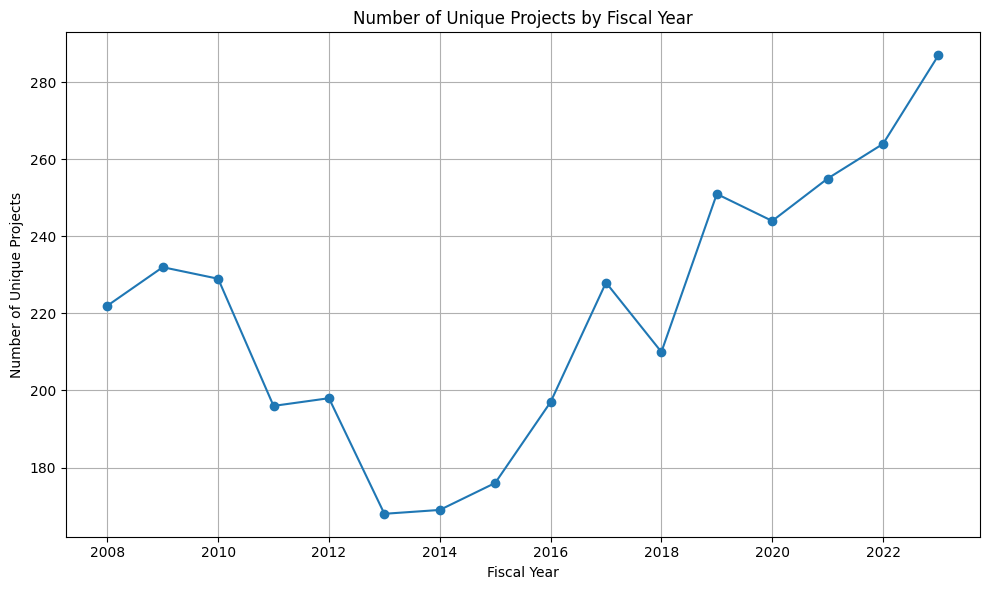

In [27]:
# Clean up column names
df.columns = df.columns.str.strip()

# Group by Fiscal Year and count unique Project Numbers
yearly_counts = df.groupby("Fiscal Year")["Project Number"].nunique().reset_index()

# Sort by Fiscal Year
yearly_counts = yearly_counts.sort_values("Fiscal Year")

# Plot as a line graph
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts["Fiscal Year"], yearly_counts["Project Number"], marker='o')
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Unique Projects")
plt.title("Number of Unique Projects by Fiscal Year")
plt.grid(True)
plt.tight_layout()
plt.show()


The line graph shows a clear trend in the number of unique NIH-funded sickle cell research projects over time. Several observations stand out:

- **2008–2014**: There is a noticeable **decline** in the number of projects, reaching a low point around 2013–2014. This may reflect broader funding constraints or shifts in NIH priorities during this period.
- **2015 onward**: Beginning in 2015, there's a **strong upward trend** in project counts, with a few fluctuations. The most dramatic growth appears between **2018 and 2023**, with the number of projects increasing each year.
- **Post-2018 growth** aligns closely with the launch and expansion of the **Cure Sickle Cell Initiative**, suggesting that targeted efforts like CureSCi may have significantly contributed to renewed investment and interest in sickle cell research.
- **2023** marks the highest number of unique projects in the dataset, reflecting a sustained and growing commitment to addressing sickle cell disease.

Overall, this trend demonstrates that sickle cell research has gained increased momentum in recent years—an encouraging sign for efforts to accelerate cures and improve outcomes for patients.


## Filtering for Sickle Cell-Focused Projects

The NIH dataset includes a wide range of projects spanning various diseases and research areas. To narrow our analysis to only those projects that are specifically related to sickle cell disease, we filter the dataset using the **`NIH Spending Categorization`** column.

This column tags each project with relevant research categories. By selecting only rows where this column includes **"Sickle Cell Disease"**, we isolate the subset of projects that the NIH has officially categorized under this focus area. 

The filtered dataset, `Sickle_Cell_Disease_df`, will serve as the primary foundation for further analysis.


In [28]:
# Filter rows where 'NIH Spending Categorization' equals 'Sickle Cell Disease'
Sickle_Cell_Disease_df = df[df["NIH Spending Categorization"].str.contains("Sickle Cell Disease", na=False)]

# Preview the result
Sickle_Cell_Disease_df.head(5)

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Award Notice Date,Opportunity Number,Project Number,Type,...,CFDA Code,Funding Mechanism,Fiscal Year,Total Cost,Total Cost(Sub Projects),Funding IC(s),Direct Cost IC,Indirect Cost IC,NIH COVID-19 Response,Total Cost IC
0,Clinical Research; Hematology; Rare Diseases; ...,Clinical Trials;Collaborations;Data Set;Diseas...,Collaborative Health Research Initiative Progr...,NaN,NHLBI,10975134,,,AHL14007001-1-0-1,,...,,Interagency Agreements,2023,606874.00,NaN,NHLBI,NaN,NaN,,606874.00
1,Biotechnology; Clinical Research; Clinical Tri...,Advocate;Caregivers;Collaborations;Communities...,Cure Sickle Cell,NaN,NHLBI,10934820,9/26/2023,OTA-18-003,3OT3HL147741-01S4,3,...,837,Other,2023,3729772.00,NaN,NHLBI,3729772.00,0.00,,3729772.00
2,Biotechnology; Hematology; Rare Diseases; Sick...,Address;Agreement;Annual Reports;Award;Biotech...,CureSC Manufacturing Resource Platform,NaN,NHLBI,10934634,9/26/2023,OTA-19-010,3OT3HL152932-01S3,3,...,837,Other,2023,1389793.00,NaN,NHLBI,1389793.00,0.00,,1389793.00
4,Clinical Research; Clinical Trials and Support...,Adverse event;Biological Markers;Cellular Meta...,A Phase 1 Study to Evaluate the Safety and Tol...,NaN,NHLBI,10930552,,,1ZIAHL006284-01,1,...,,Intramural Research,2023,114449.00,NaN,NHLBI,NaN,NaN,,114449.00
5,Bioengineering; Cardiovascular; Clinical Resea...,Abnormal Hemoglobins;Acute;Adopted;Affect;Afri...,Exploring Near Infrared Spectroscopy (NIRS) te...,NaN,NHLBI,10929214,,,1ZIAHL006283-01,1,...,,Intramural Research,2023,986763.00,NaN,NHLBI,NaN,NaN,,986763.00


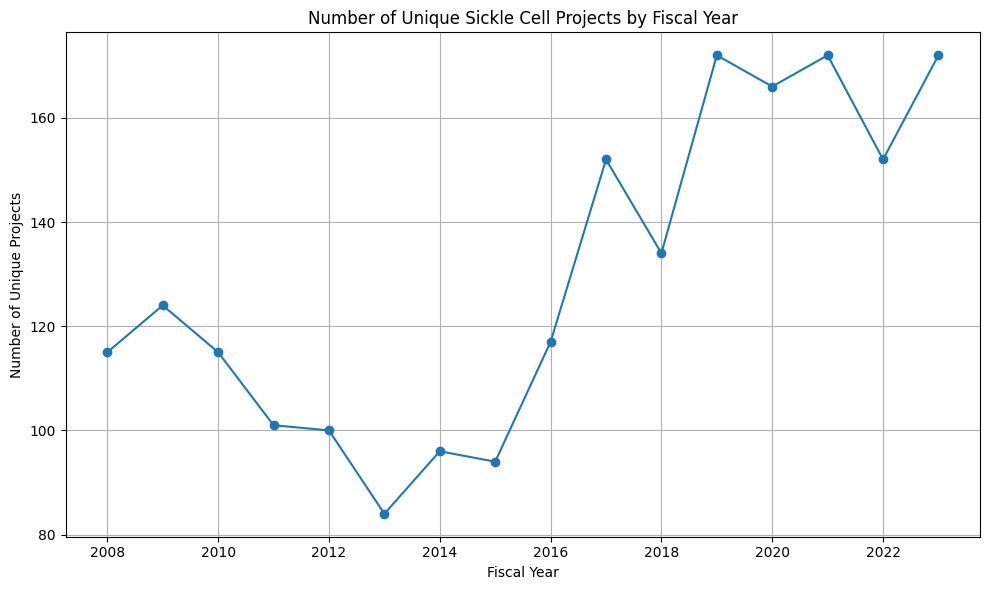

In [29]:
# Group by Fiscal Year and count unique Project Numbers
yearly_counts = Sickle_Cell_Disease_df.groupby("Fiscal Year")["Project Number"].nunique().reset_index()

# Sort by Fiscal Year
yearly_counts = yearly_counts.sort_values("Fiscal Year")

# Plot as a line graph
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts["Fiscal Year"], yearly_counts["Project Number"], marker='o')
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Unique Projects")
plt.title("Number of Unique Sickle Cell Projects by Fiscal Year")
plt.grid(True)
plt.tight_layout()
plt.show()

## Funding totals by fiscal year
Summing total costs by fiscal year shows how much money is going to sickle cell projects over time.


In [ ]:
# Sum total cost by fiscal year for sickle cell projects
funding_by_year = (
    Sickle_Cell_Disease_df.groupby('Fiscal Year')['Total Cost']
    .sum()
    .reset_index()
    .sort_values('Fiscal Year')
)

# Show totals in millions for readability
funding_by_year['Total Cost (Millions)'] = funding_by_year['Total Cost'] / 1e6
display(funding_by_year[['Fiscal Year', 'Total Cost (Millions)']].head())

plt.figure(figsize=(10, 6))
sns.barplot(data=funding_by_year, x='Fiscal Year', y='Total Cost (Millions)', color='skyblue')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Cost (Millions USD)')
plt.title('Total Sickle Cell Project Funding by Fiscal Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Comparing NHLBI funding across related areas
To see how sickle cell funding stacks up against other NHLBI hematology efforts, we can compare fiscal-year totals for the broader hematology portfolio and Cooley's anemia awards.


In [ ]:
# Load hematology and Cooley's anemia datasets and compute yearly totals
def load_totals(csv_path, label, skiprows=0):
    temp_df = pd.read_csv(csv_path, encoding='latin-1', skiprows=skiprows)
    temp_df.columns = temp_df.columns.str.strip()
    temp_df = temp_df.loc[:, temp_df.columns != '']

    cost_cols = [
        'Total Cost', 'Total Cost(Sub Projects)',
        'Direct Cost IC', 'Indirect Cost IC', 'Total Cost IC'
    ]
    for c in cost_cols:
        if c in temp_df.columns:
            temp_df[c] = (
                temp_df[c]
                .replace(r'[$,]', '', regex=True)
                .replace(r'^\s*$', None, regex=True)
                .astype(float)
            )

    totals = (
        temp_df.groupby('Fiscal Year')['Total Cost']
        .sum()
        .reset_index()
        .assign(Dataset=label)
        .sort_values('Fiscal Year')
    )
    return totals

hematology_totals = load_totals(path + '/Hemotology_NHLBI.csv', 'Hematology (NHLBI)', skiprows=9)
cooleys_totals = load_totals(path + '/NHLBI_Cooleys_Anemia.csv', "Cooley's Anemia")

# Combine with sickle cell totals computed earlier
sickle_totals = funding_by_year[['Fiscal Year', 'Total Cost']].copy()
sickle_totals['Dataset'] = 'Sickle Cell Disease'

comparison_totals = pd.concat([sickle_totals, hematology_totals, cooleys_totals], ignore_index=True)
comparison_totals['Total Cost (Millions)'] = comparison_totals['Total Cost'] / 1e6

display(comparison_totals.head())
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_totals, x='Fiscal Year', y='Total Cost (Millions)', hue='Dataset')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Cost (Millions USD)')
plt.title('NHLBI Funding by Fiscal Year: Sickle Cell vs. Other Hematology Areas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Graph Number of Sickle Cell and Gene Therapy Projects By Start Date (Year)

### This is done since projects can span more than one fiscal year

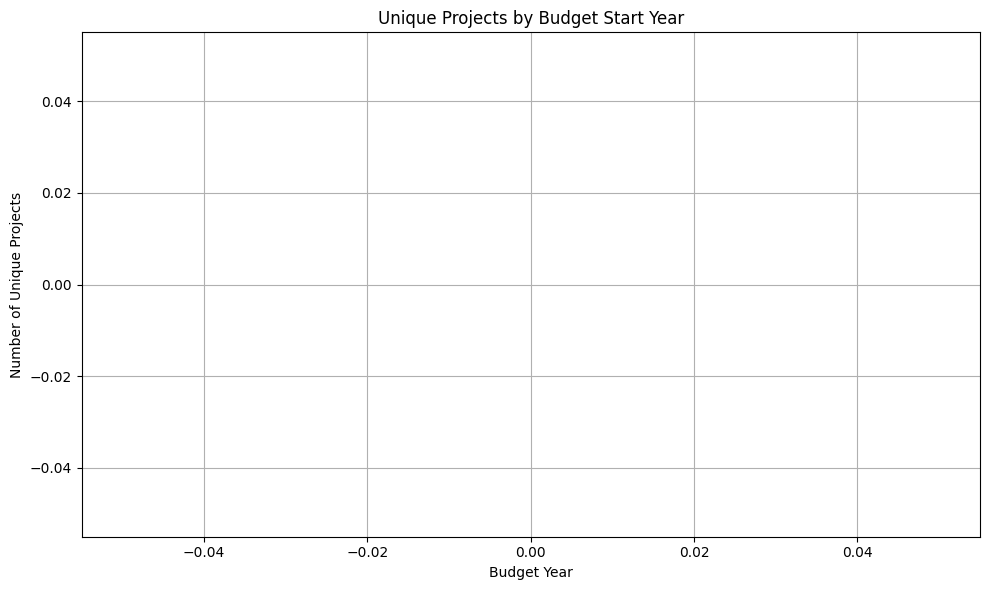

In [33]:
# Convert 'Budget Start Date' to datetime format
df["Budget Start Date"] = pd.to_datetime(df["Budget Start Date"], format="%m/%d/%y", errors='coerce')

# Extract the year as a new column
df["Budget Year"] = df["Budget Start Date"].dt.year

# Group by year and count unique project numbers
yearly_project_counts = df.groupby("Budget Year")["Project Number"].nunique().reset_index()

# Sort by year
yearly_project_counts = yearly_project_counts.sort_values("Budget Year")

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(yearly_project_counts["Budget Year"], yearly_project_counts["Project Number"], marker='o')
plt.xlabel("Budget Year")
plt.ylabel("Number of Unique Projects")
plt.title("Unique Projects by Budget Start Year")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\NAjani\AppData\Local\Temp\ipykernel_10324\1542348314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sickle_Cell_Disease_df["Budget Start Date"] = pd.to_datetime(df["Budget Start Date"], format="%m/%d/%y", errors='coerce')
C:\Users\NAjani\AppData\Local\Temp\ipykernel_10324\1542348314.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sickle_Cell_Disease_df["Budget Year"] = Sickle_Cell_Disease_df["Budget Start Date"].dt.year


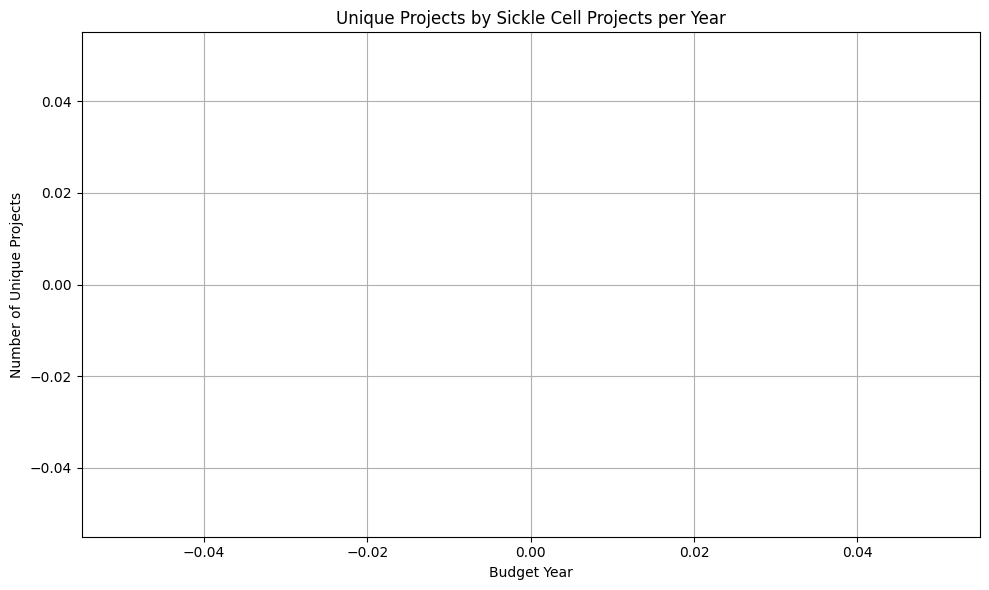

In [34]:
# Convert 'Budget Start Date' to datetime format
Sickle_Cell_Disease_df["Budget Start Date"] = pd.to_datetime(df["Budget Start Date"], format="%m/%d/%y", errors='coerce')

# Extract the year as a new column
Sickle_Cell_Disease_df["Budget Year"] = Sickle_Cell_Disease_df["Budget Start Date"].dt.year

# Group by year and count unique project numbers
yearly_project_counts = Sickle_Cell_Disease_df.groupby("Budget Year")["Project Number"].nunique().reset_index()

# Sort by year
yearly_project_counts = yearly_project_counts.sort_values("Budget Year")

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(yearly_project_counts["Budget Year"], yearly_project_counts["Project Number"], marker='o')
plt.xlabel("Budget Year")
plt.ylabel("Number of Unique Projects")
plt.title("Unique Projects by Sickle Cell Projects per Year")
plt.grid(True)
plt.tight_layout()
plt.show()

Filling 'Project Title' and 'Public Health Relevance' that have missing values with empty strings